## 8) BiLSTM으로 한국어 스팀 리뷰 감성 분류하기

이번 챕터에서는 게임 플랫폼 스팀에 등록된 한국어 리뷰에 대해서 감성 분석을 진행해보겠다. 이 데이터는 긍정인 리뷰에는 레이블 1이, 부정인 리뷰에는 레이블 0이 부여되어져 있다. 앞서 진행했던 감성 분류 문제들과 마찬가지로 이진 분류 문제를 푼다.



### 1.BiLSTM을 텍스트 분류에 사용하기

<img src = 'https://wikidocs.net/images/page/94748/bilstm1.PNG' width = 60%>

양방향 LSTM은 두 개의 독립적인 LSTM 아키텍처를 함께 사용하는 구조이다. 위 그림에서 주황색 LSTM 셀은 순차적으로 입력을 받는다. 자연어 처리라고 한다면, 마치 사람처럼 문장을 왼쪽 단어부터 순차적으로 읽는 셈이다. 양방향 LSTM은 뒤의 문맥까지 고려하기 위해서 문장을 오른쪽에서 반대로 읽는 역방향의 LSTM 셀(위 그림에서 초록색)을 함께 사용한다. 이 두 가지 정보를 고려하여 출력층에서 예측 시에 두 가지 정보를 모두 사용한다.

위 그림은 다-대-다(Many-to-Many) 문제를 푸는 경우의 양방향 LSTM을 보여주고 있다. 그런데 양방향 LSTM을 다-대-일(Many-to-One) 문제인 텍스트 분류 문제에 사용한다고 하면, 한 가지 의문이 생긴다.

<img src = 'https://wikidocs.net/images/page/94748/bilstm2.PNG' width = 60%>

일반적으로 정방향 LSTM은 마지막 시점의 은닉 상태를 출력층으로 보내서 텍스트 분류를 수행한다. 그렇다면 역방향 LSTM도 정방향과 같은 시점의 은닉 상태를 사용하면 될까? 위 그림과 같이 텍스트 분류를 진행하는 경우, 역방향 LSTM은 $x_{4}$만 본 상태이다. 이 경우 역방향 LSTM이 텍스트 분류를 위한 유용한 정보를 갖고 있다고 기대하기 어렵다.

<img src = 'https://wikidocs.net/images/page/94748/bilstm3.PNG' width = 60%>

그래서 케라스에서는 양방향 LSTM을 사용하면서 return_sequences = False를 택할 경우에는 위의 그림과 같이 동작하고 있다. 정방향 LSTM의 경우에는 마지막 시점의 은닉 상태를 반환하고, 역방향 LSTM의 경우에는 첫번째 시점의 은닉 상태를 반환한다. 위 구조를 통해서 양방향 LSTM으로 텍스트 분류를 수행할 수 있다.


### 2.Colab에 Mecab 설치

이번 챕터에서는 형태소 분석기 Mecab을 사용한다. 여기서는 Mecab을 편하게 사용하기 위해서 구글의 Colab을 사용하였다. 우선, Colab에서 Mecab을 설치한다. 참고로 윈도우에서는 Mecab 설치 방법이 다르기 때문에 아래 커맨드를 주피터 노트북에 입력하더라도 Mecab이 설치되지 않는다. 그래서 가급적 저자와 같은 환경인 Colab에서 실습을 권장한다.



In [1]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 75 (delta 33), reused 21 (delta 5), pack-reused 0
Unpacking objects: 100% (75/75), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4MB 147kB/s 
     |████████████████████████████████| 460kB 46.8MB/s 
     |████████████████████████████████| 92kB 13.4MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-01-12 11:49:40--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz

### 3.스팀 리뷰 데이터에 대한 이해와 전처리

다운로드 링크 : https://github.com/bab2min/corpus/tree/master/sentiment


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn-white'])
import urllib.request

from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#### 1) 데이터 로드하기



In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt",
                           filename="steam.txt")


('steam.txt', <http.client.HTTPMessage at 0x7fe5bef817f0>)

해당 데이터에는 열제목이 별도로 없다. 그래서 임의로 두 개의 열제목인 'label'과 'reviews'를 추가해주겠다.


In [4]:
total_data = pd.read_table('steam.txt', names = ['label', 'reviews'])
print('전체 리뷰 개수 :', len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 100000


총 10만개의 샘플이 존재한다. 상위 5개의 샘플만 출력해보자.


In [5]:
total_data[:5]

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


각 열에 대해서 중복을 제외한 샘플의 수를 카운트한다.


In [6]:
total_data['reviews'].nunique(), total_data['label'].nunique()

(99892, 2)

reviews열에서 중복을 제외한 경우 99,892개이다. 현재 10만개의 리뷰가 존재하므로 이는 현재 갖고 있는 데이터에 중복인 샘플들이 있다는 의미이다. 중복인 샘플들을 제거해준다.


In [7]:
total_data.drop_duplicates(subset = ['reviews'], inplace = True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :', len(total_data))

총 샘플의 수 : 99892


NULL 값 유무를 확인한다.


In [8]:
print(total_data.isnull().values.any())

False


#### 2) 훈련 데이터와 테스트 데이터 분리하기

훈련 데이터와 테스트 데이터를 3:1 비율로 분리한다.

In [9]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, 
                                         random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 74919
테스트용 리뷰의 개수 : 24973


훈련용 리뷰의 경우 약 7만 5,000개. 테스트용 리뷰의 경우 약 2만 5,000개가 존재한다.

#### 3) 레이블의 분포 확인

훈련 데이터의 레이블의 분포를 확인해보자.

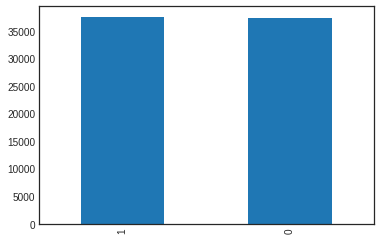

In [10]:
train_data['label'].value_counts().plot(kind = 'bar')

In [11]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  37376
1      1  37543


두 레이블 모두 약 3만 7천개로 50:50 비율을 가지고 있다. 


#### 4) 데이터 정제하기

정규 표현식을 사용하여 한글을 제외하고 모두 제거해준다. 또한 혹시 이 과정에서 빈 샘플이 생기지는 않는지 확인한다.


In [12]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
train_data['reviews'].replace('', np.nan, inplace = True)
print(train_data.isnull().sum())

label      0
reviews    0
dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


테스트 데이터에 대해서도 같은 과정을 거친다.


In [13]:
test_data.drop_duplicates(subset = ['reviews'], inplace = True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace = True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how = 'any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :', len(test_data))

전처리 후 테스트용 샘플의 개수 : 24973


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

이제 불용어를 정의해준다.


In [14]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']


#### 5) 토큰화

형태소 분석기 Mecab을 사용하여 토큰화 작업을 수행한다. 다음은 임의의 문장에 대해서 테스트한 토큰화 결과이다.


In [15]:
mecab = Mecab()

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#### 6) 단어와 길이 분포 확인하기

긍정 리뷰에는 주로 어떤 단어들이 많이 등장하고, 부정 리뷰에는 주로 어떤 단어들이 등장하는지 두 가지 경우에 대해서 각 단어의 빈도수를 계산해보겠다. 각 레이블에 따라서 별도로 단어들의 리스트를 저장해준다.


In [16]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

Counter()를 사용하여 각 단어에 대한 빈도수를 카운트한다. 우선 부정 리뷰에 대해서 빈도수가 높은 상위 20개 단어들을 출력한다.


In [17]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('안', 8129), ('없', 7141), ('는데', 5786), ('있', 5692), ('같', 4247), ('로', 4083), ('할', 3920), ('거', 3902), ('나', 3805), ('해', 3653), ('너무', 3522), ('으로', 3351), ('기', 3348), ('했', 3265), ('어', 3143), ('보', 2987), ('습니다', 2962), ('것', 2935), ('지만', 2911), ('좋', 2899)]


긍정 리뷰에 대해서도 동일하게 출력해보자.


In [18]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('있', 9987), ('좋', 6542), ('습니다', 5179), ('재밌', 4997), ('할', 4838), ('지만', 4809), ('해', 4354), ('없', 4145), ('보', 3907), ('으로', 3900), ('로', 3879), ('수', 3835), ('는데', 3825), ('기', 3592), ('안', 3368), ('것', 3362), ('같', 3356), ('네요', 3189), ('어', 3112), ('나', 3055)]


두 가지 경우에 대해서 각각 길이 분포를 확인해보자.


긍정 리뷰의 평균 길이 : 14.948459100231734
부정 리뷰의 평균 길이 : 15.284193065068493


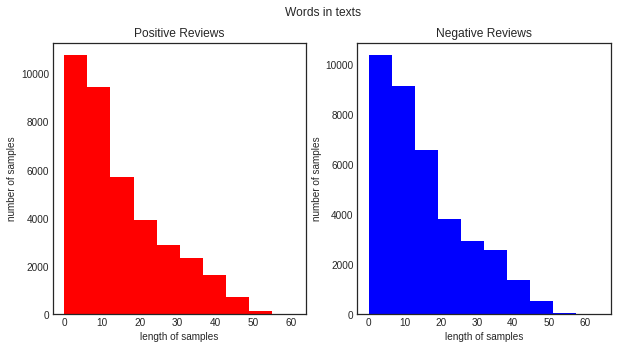

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

text_len = train_data[train_data['label'] == 1]['tokenized'].map(lambda x: len(x))

ax1.hist(text_len, color = 'red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label'] == 0]['tokenized'].map(lambda x: len(x))

ax2.hist(text_len, color = 'blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

유의미한 차이가 있는 것 같지는 않다.


In [20]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values

X_test = test_data['tokenized'].values
y_test = test_data['label'].values

#### 7) 정수 인코딩

이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 한다. 우선, 훈련 데이터에 대해서 단어 집합(vocabulary)을 만들어보자.


In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다. 이는 tokenizer.word_index를 출력하여 확인 가능하다. 등장 횟수가 1회인 단어들은 자연어 처리에서 배제하고자 한다. 이 단어들이 이 데이터에서 얼마만큼의 비중을 차지하는지 확인해보자.


In [22]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' % (threshold -1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율:', (rare_cnt / total_cnt) * 100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율:', (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기 : 32817
등장 빈도가 1번 이하인 희귀 단어의 수: 13878
단어 집합에서 희귀 단어의 비율: 42.28905750068562
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.2254607619437832


단어가 약 32,000개가 존재한다. 등장 빈도가 threshold 값인 2회 미만. 즉, 1회인 단어들은 단어 집합에서 약 42%를 차지한다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 매우 적은 수치인 약 1.2%밖에 되지 않는다. 아무래도 등장 빈도가 1회인 단어들은 자연어 처리에서 별로 중요하지 않을 듯 하다. 그래서 이 단어들은 정수 인코딩 과정에서 배제시키겠다.

등장 빈도수가 1인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한하겠다.


In [23]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 18941


이제 단어 집합의 크기는 18,941개이다. 이를 토크나이저의 인자로 넘겨주면, 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환한다. 이러한 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환하겠다.



In [24]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

정수 인코딩이 진행되었는지 확인하고자 X_train과 X_test에 대해서 상위 3개의 샘플만 출력한다.


In [25]:
print(X_train[:3])

[[495, 7, 35, 87, 149, 2429, 599, 26, 8, 70, 47, 235, 111, 38, 44, 52], [161, 300, 18, 20, 63, 3582, 985, 6, 56], [7, 17, 1476, 4]]


In [26]:
print(X_test[:3])

[[728, 34, 16, 431, 52, 106, 132, 99, 6461, 453], [4527, 687, 835, 712, 792, 108, 4, 1779, 95, 370, 3518, 81, 558, 1904, 4189, 262, 169, 61, 25, 363, 35, 87, 974, 19, 6294, 6422], [1792, 806, 685, 49, 23, 349]]


#### 8) 패딩

이제 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행해보겠다. 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 알아보겠다.

리뷰의 최대 길이 : 64
리뷰의 평균 길이 : 15.115951894712957


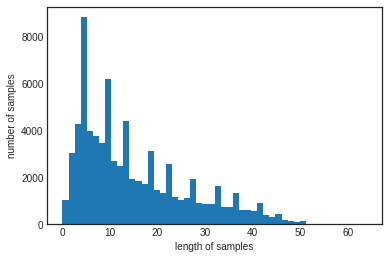

In [27]:
print('리뷰의 최대 길이 :', max(len(l) for l in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train)) / len(X_train))

plt.hist([len(s) for s in X_train], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

리뷰의 최대 길이는 64, 평균 길이는 약 15이다. 그리고 그래프로 보았을 때, 전체적으로는 60이하의 길이를 가지는 것으로 보인다.


In [28]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if (len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s' % (max_len, (cnt / len(nested_list)) * 100))
    

최대 길이가 64이므로 만약 60으로 패딩할 경우, 몇 개의 샘플들을 온전히 보전할 수 있는지 확인해보자.


In [29]:
max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.99599567532935


훈련용 리뷰의 99.99%가 60이하의 길이를 가진다. 훈련용 리뷰를 길이 60으로 패딩하겠다.


In [30]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test  = pad_sequences(X_test , maxlen = max_len)

### 4.BiLSTM으로 스팀 리뷰 감성 분류하기



In [31]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [32]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1894100   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 2,055,101
Trainable params: 2,055,101
Non-trainable params: 0
_________________________________________________________________


In [33]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max',
                     verbose = 1, save_best_only = True)

In [34]:
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['acc'])

In [35]:
hist = model.fit(X_train, y_train,
                 epochs = 15,
                 callbacks = [es, mc],
                 batch_size = 256, 
                 validation_split = 0.2, verbose = 1)

Epoch 1/15
235/235 [==============================] - 15s 27ms/step - loss: 0.6004 - acc: 0.6878 - val_loss: 0.5037 - val_acc: 0.7666

Epoch 00001: val_acc improved from -inf to 0.76662, saving model to best_model.h5
Epoch 2/15
235/235 [==============================] - 5s 23ms/step - loss: 0.4347 - acc: 0.7992 - val_loss: 0.4621 - val_acc: 0.7888

Epoch 00002: val_acc improved from 0.76662 to 0.78877, saving model to best_model.h5
Epoch 3/15
235/235 [==============================] - 5s 23ms/step - loss: 0.4023 - acc: 0.8226 - val_loss: 0.4623 - val_acc: 0.7850

Epoch 00003: val_acc did not improve from 0.78877
Epoch 4/15
235/235 [==============================] - 5s 23ms/step - loss: 0.3806 - acc: 0.8342 - val_loss: 0.4631 - val_acc: 0.7870

Epoch 00004: val_acc did not improve from 0.78877
Epoch 5/15
235/235 [==============================] - 5s 23ms/step - loss: 0.3581 - acc: 0.8460 - val_loss: 0.4935 - val_acc: 0.7847

Epoch 00005: val_acc did not improve from 0.78877
Epoch 6/15
2

In [37]:
loaded_model = load_model('best_model.h5')
print('테스트 정확도: %.4f' % (loaded_model.evaluate(X_test, y_test)[1]))


781/781 [==============================] - 4s 5ms/step - loss: 0.4634 - acc: 0.7838
테스트 정확도: 0.7838


### 5.리뷰 예측해보기


In [38]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', new_sentence)
    new_sentence = mecab.morphs(new_sentence)
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측

    if (score > 0.5):
        print('{:.2f}% 확률로 긍정 리뷰입니다.'.format(score * 100))
    else:
        print('{:.2f}% 확률로 부정 리뷰입니다.'.format((1 - score) * 100))
        

In [39]:
sentiment_predict('노잼 ..완전 재미 없음 ㅉㅉ')

89.34% 확률로 부정 리뷰입니다.


In [40]:
sentiment_predict('조금 어렵지만 재밌음ㅋㅋ')

97.09% 확률로 긍정 리뷰입니다.


In [41]:
sentiment_predict('케릭터가 예뻐서 좋아요')

89.30% 확률로 긍정 리뷰입니다.


https://towardsdatascience.com/understanding-bidirectional-rnn-in-pytorch-5bd25a5dd66
